<a href="https://colab.research.google.com/github/NizarMohd/RunOrWalk/blob/main/3-ClassMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://www.kaggle.com/nirajvermafcb/principal-component-analysis-with-scikit-learn


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


df=pd.read_csv('features_test1.csv') #Replace it with your path where the data file is stored
df.head()
df.describe()



,min ax,min ay,min az,min gx,min gy,min gz,max ax,max ay,max az,max gx,max gy,max gz,mean ax,mean ay,mean az,mean gx,mean gy,mean gz,label
count,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000
mean,-114.143034,4.374691,-102.744023,-4.782770,-92.311212,-107.752679,85.375515,113.582852,103.153751,-4.551113,110.658697,91.038335,-29.771228,57.315334,5.275763,-4.551113,-5.436109,-0.499588,1.270816
std,33.852740,37.042524,55.398552,0.664418,37.062489,33.588582,50.167772,34.503930,26.813904,0.696430,34.402250,35.987096,16.659179,27.637370,26.319390,0.696430,12.012066,8.419136,0.713081
min,-127.000000,-127.000000,-127.000000,-6.000000,-127.000000,-127.000000,-43.000000,-47.000000,-1.000000,-6.000000,-23.000000,-1.000000,-101.000000,-61.000000,-43.000000,-6.000000,-49.000000,-42.000000,0.000000
25%,-127.000000,-24.000000,-127.000000,-5.000000,-127.000000,-127.000000,37.000000,127.000000,82.000000,-5.000000,127.000000,66.000000,-39.000000,44.000000,-14.000000,-5.000000,-15.000000,-5.000000,1.000000
50%,-127.000000,-1.000000,-127.000000,-5.000000,-101.000000,-127.000000,127.000000,127.000000,114.000000,-5.000000,127.000000,95.000000,-33.000000,56.000000,-1.000000,-5.000000,-3.000000,0.000000,1.000000
75%,-127.000000,43.000000,-127.000000,-5.000000,-62.000000,-99.000000,127.000000,127.000000,127.000000,-4.000000,127.000000,127.000000,-26.000000,83.000000,17.000000,-4.000000,4.000000,4.000000,2.000000
max,28.000000,61.000000,66.000000,-1.000000,-2.000000,2.000000,127.000000,127.000000,127.000000,-1.000000,127.000000,127.000000,59.000000,99.000000,73.000000,-1.000000,28.000000,42.000000,2.000000


Text(0.5, 1.0, 'Correlation between different features')

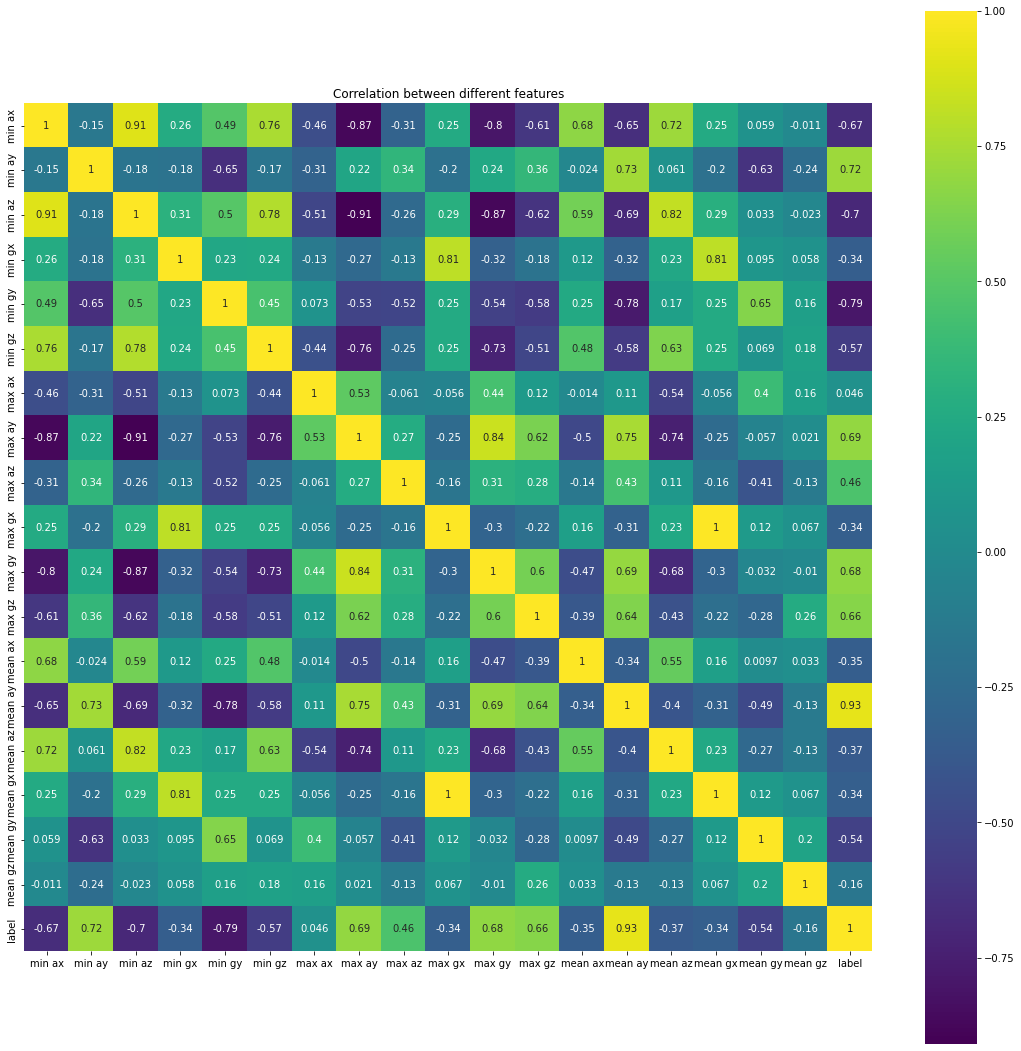

In [2]:
correlation = df.corr()
plt.figure(figsize=(19,19))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

plt.title('Correlation between different features')

### **1. Preparation**



**Check Python version.**

In [3]:
!python -V

Python 3.7.12


**Check Cuda version.**

In [4]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


**Install dependencies.**

In [5]:
pip install torch torchvision

In [6]:
pip install opencv-python

**Check GPU usage.**

In [7]:
# Check if runtime uses GPU
import torch

gpu_name = torch.cuda.get_device_name(0)

print("Using GPU", gpu_name)

Using GPU Tesla P100-PCIE-16GB


Load Dataset

In [8]:

# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Dropout
from torch.optim import Adam, SGD
import tensorflow as tf
from torchvision import transforms
from torchvision.transforms import *
from sklearn.utils import shuffle

datasets = pd.read_csv('features_test1.csv')
datasets.dropna()
datasets = shuffle(datasets)


train_set, test_set = train_test_split(datasets, test_size = 0.1)
train_set = train_set.dropna()

print(len(train_set))


test_set, val_set = train_test_split(test_set, test_size = 0.5)
test_set.dropna()
val_set.dropna()

k_fold = 10
seg = round(1/k_fold * len(train_set))
class MyDataset(Dataset):
  
    def __init__(self, type):

      # # compute k_fold segments
      # val_l = int(seg * k)
      # val_r = int(val_l + seg)

      # val_set = train_set.iloc[val_l:val_r]
      # training_set = train_set.drop(val_set.index)
      if type == "train":
        self.data = train_set
      elif type == "test":
        self.data = test_set
      elif type == "val":
        self.data = val_set
      print(f'loaded data with dataset size {len(self)}')
      # print("Val left index: " + str(val_l))
      # print("Val right index: " + str(val_r))
 
      
    def __getitem__(self, idx):
        classes = 3
        # print(self.data.iloc[idx])
        # sys.stdout.flush()
        item = self.data.iloc[idx] 
        image = item[0:18]
        label = item[18]
        image = torch.from_numpy(np.array(image))
        labels = []
        for i in range(classes):
            if i == label:
              labels.append(1)
            else:
              labels.append(0)
        labels = torch.IntTensor(labels)
        return image, labels

    def __len__(self):
        return len(self.data)


2183


**MLP** Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F
class Model(nn.Module):
  
  def __init__(self):
    super(Model, self).__init__()
    n_input = 18
    n_h1 = 512
    n_h2 = 256
    n_h3 = 16
    n_output = 3

    self.h1 = nn.Linear(n_input, n_h1)
    self.h2 = nn.Linear(n_h1, n_h2)
    self.h3 = nn.Linear(n_h2, n_h3)
    self.output = nn.Linear(n_h3, n_output)

    print(self)
  
  def forward(self, x):
    x = F.relu(self.h1(x))
    x = F.relu(self.h2(x))
    x = F.relu(self.h3(x))
    x = self.output(x)
    return x


# class Net(nn.Module):   
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(24,12)    # input layer
#         self.fc2 = nn.Linear(12, 6)            # hidden layer
#         self.out = nn.Linear(6, 2)
        

#     # Defining the forward pass    
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.out(x)
#         return x


Train Model

In [10]:
from torch import optim
from sklearn.model_selection import StratifiedKFold

def accuracy_score(outputs, targets):
  sum = 0
  batch_size = targets.size(0)
  
  for i in range(batch_size):
    index_O = outputs.cpu().data.numpy()[i].argmax()
    index_T = targets.cpu().data.numpy()[i].argmax()

    if index_O == index_T:
      sum = sum + 1
  return sum / batch_size

def train():
  batch_size = 64
  num_epochs = 200
  num_workers = 2

  model = Model()
  model = model.cuda().float()
  
  loss_fn = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(),lr = 0.00001, momentum= 0.9, nesterov = True)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.3, verbose=True)


  
  train_set = MyDataset("train")
  validation_set = MyDataset("val")

  train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(
        validation_set, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=False)

  for epoch in range(num_epochs):
    train_loss, valid_loss = [], []
    train_acc , val_acc = [], []
    # train
    model.train()

    # #quantize model
    # model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    # model = torch.quantization.prepare_qat(model, inplace=True)

    for i, (data, target) in enumerate(train_loader):
        data, target = data.cuda().float(), target.cuda().float()
        # clear gradients
        optimizer.zero_grad()

        # forward prop
        prediction = model(data)

        # loss calculation
        loss = loss_fn(prediction, target)

        #backward prop
        loss.backward()

        ## weight optimization
        optimizer.step()

        train_loss.append(loss.item())
        train_acc.append(accuracy_score(prediction, target))

        if i % 100 == 99:
                print(f'training: iteration {i} / {len(train_loader)}, avg train loss = {np.mean(train_loss):.4f}, '
                      f'train accuracy {np.mean(train_acc):.4f}')
    
    # eval
    model.eval()
    for i, (data, target) in enumerate(validation_loader):
        data, target = data.cuda().float(), target.cuda().float()
        prediction = model(data)
        loss = loss_fn(prediction, target)
        valid_loss.append(loss.item())
        val_acc.append(accuracy_score(prediction, target))

        if i % 100 == 99:
                print(f'validation: iteration {i} / {len(validation_loader)}, avg val loss = {np.mean(train_loss):.4f}, '
                      f'val accuracy {val_acc.avg:.4f}')

    # epoch summary
    print("Epoch:", epoch, "Train Loss:", np.mean(train_loss), "Train acc:", np.mean(train_acc), "Val Loss:", np.mean(valid_loss), "Val Acc:",  np.mean(val_acc))

    # lr scheduler
    scheduler.step(np.mean(valid_loss))

    # checkpoint
    if epoch % 2 == 10:
        torch.save(model.state_dict(), f'ckpt_e{epoch}.pth')
    
  torch.save(model.state_dict(), 'A0183398M-Model.pth')



  

if __name__ == "__main__":
    train()


Model(
  (h1): Linear(in_features=18, out_features=512, bias=True)
  (h2): Linear(in_features=512, out_features=256, bias=True)
  (h3): Linear(in_features=256, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
)
loaded data with dataset size 2183
loaded data with dataset size 122
Epoch: 0 Train Loss: 0.7479877646480287 Train acc: 0.43730867346938773 Val Loss: 0.23562442511320114 Val Acc: 0.4835668103448276
Epoch: 1 Train Loss: 0.23874208331108093 Train acc: 0.4828443877551021 Val Loss: 0.221050925552845 Val Acc: 0.4921875
Epoch: 2 Train Loss: 0.22638614518301828 Train acc: 0.4940051020408164 Val Loss: 0.21413622796535492 Val Acc: 0.5328663793103448
Epoch: 3 Train Loss: 0.22039174096924918 Train acc: 0.5024872448979593 Val Loss: 0.2093900814652443 Val Acc: 0.5571120689655172
Epoch: 4 Train Loss: 0.21565710263592855 Train acc: 0.5068877551020408 Val Loss: 0.2058211714029312 Val Acc: 0.5649245689655172
Epoch: 5 Train Loss: 0.2111441207783563 Train a

Test Accuracy

In [11]:
from torch.nn.modules.container import ModuleList
import torch
from torch import nn
# Change [your_python_file] to the actual file containing the definitons of the classes


def test():
    my_model = Model()
    my_model = my_model.cuda()
    my_model.eval()

    my_model.load_state_dict(torch.load('A0183398M-Model.pth'))
    
    
    test_set = MyDataset("test")
    batch_size = 64


    # mp.set_start_method('spawn', force=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, \
                      shuffle=False)

    # test accuracy
    test_acc = []
    for i, (image,label) in enumerate(test_loader):
        image, label = image.cuda().float(), label.cuda().float()
        with torch.no_grad():
            prediction = my_model(image)
            acc = accuracy_score(prediction, label)
            test_acc.append(acc)

        if i % 10 == 9:
            print(f'test: iteration {i} / {len(test_loader)}, '
                  f'test accuracy {np.mean(test_acc):.4f}')

    print(f'evaluation finished, val acc {np.mean(test_acc):.4f}')

if __name__ == "__main__":
    test()

Model(
  (h1): Linear(in_features=18, out_features=512, bias=True)
  (h2): Linear(in_features=512, out_features=256, bias=True)
  (h3): Linear(in_features=256, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
)
loaded data with dataset size 121
evaluation finished, val acc 1.0000


Extract weights and biases

In [12]:
from torch import nn
import torch
import torch.quantization.quantize_fx as quantize_fx
import copy
import csv

my_model = Model()
my_model = my_model.cuda()
my_model.eval()
my_model.load_state_dict(torch.load('A0183398M-Model.pth'))
f = open('weights.csv', 'w', encoding='UTF8', newline='')
writer = csv.writer(f)

w1 = []
w2 = []
w3 = []
w4 = []

b1 = []
b2 = []
b3 = []
b4 = []

n_input = 18
n_h1 = 512
n_h2 = 256
n_h3 = 16
n_output = 3

for param_tensor in my_model.state_dict():
    # get each layer, print layer size
    print(param_tensor, "\t", my_model.state_dict()[param_tensor].size())
    print("\n")
    print(param_tensor, "\t", my_model.state_dict()[param_tensor])
    print("\n")

    # prepare min,max of each layer
    r_max = 0
    r_min = 0
    layer = my_model.state_dict()[param_tensor]

    
    # if param_tensor == 'h1.weight' or param_tensor == 'h2.weight' or param_tensor == 'output.weight':
    #   # writer.writerow("weights")
    #   print("weights")
    #   #layer is 2D array
    #   for row in layer:
    #     if r_max < max(row.cpu().numpy()):
    #       r_max = max(row.cpu().numpy())      
    #     if r_min > min(row.cpu().numpy()):
    #       r_min = min(row.cpu().numpy())
    # else:
    #   # layer is 1D array
    #   # writer.writerow("bias")
    #   print("bias")
    #   r_max = max(layer.cpu().numpy())
    #   r_min = min(layer.cpu().numpy())

    # s = 2 / (r_max - r_min)
    # c = -1 - s * r_min
    out = []

    
    r = 0
  

    if param_tensor == 'h1.weight' or param_tensor == 'h2.weight'  or param_tensor == 'h3.weight' or param_tensor == 'output.weight':
      #layer is 2D array
      for row in layer:
        r = r + 1
        for item in row:
          y = item.item() * (10**3)
          out.append(round(y))
          if param_tensor == 'h1.weight':
            w1.append(round(y))
          elif param_tensor == 'h2.weight':
            w2.append(round(y))
          elif param_tensor == 'h3.weight':
            w3.append(round(y))
          else:
            w4.append(round(y))
          

      
    else:
      # layer is 1D array
      for item in layer:
          r = r + 1
          y = item.item() * (10**3)
          
          out.append(round(y))
          if param_tensor == 'h1.bias':
            b1.append(round(y))
          elif param_tensor == 'h2.bias':
            b2.append(round(y))
          elif param_tensor == 'h3.bias':
            b3.append(round(y))
          else:
            b4.append(round(y))

    print(r)
    print(out)
    
    print("\n")


#  compute accuracy of quantized weights


test_set = MyDataset("test")
batch_size = 64


# mp.set_start_method('spawn', force=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, \
                  shuffle=False)

# test accuracy
test_acc = []



for k, (image,label) in enumerate(test_loader):
        
        acc = 0
        idx = 0
        preds = []
        for data in image:
          z1 = []
          z2 = []
          z3 = []
          z4 = []
          # 24 attr, 64 data
          # compute Z1 = W1x + b1
          j = 0
          z = 0
          x = data.numpy()
          for i in range(0, n_h1 * n_input):
            z = w1[i] * x[i%n_input] + z
            if i% n_input == n_input - 1:
              z = z + b1[j]
              j = j + 1
              if z < 0:
                z = 0
              z1. append(round(z/1000))
              z = 0
          

          # compute z2 = w2 * z1 + b2
          j = 0
          z = 0
          for i in range(0, n_h2 * n_h1):
            z = w2[i] * z1[i%n_h1] + z
            if i% n_h1 == n_h1 - 1:
              z = z + b2[j]
              j = j + 1
              if z < 0:
                z = 0
              z2.append(round(z/1000))
              z = 0 
          
          j = 0
          z = 0
          for i in range(0, n_h3 * n_h2):
            z = w3[i] * z2[i%n_h2] + z
            if i% n_h2 == n_h2 - 1:
              z = z + b3[j]
              j = j + 1
              if z < 0:
                z = 0
              z3.append(round(z/1000))
              z = 0 

          j = 0
          z = 0
          for i in range(0, n_output * n_h3):
            z = w4[i] * z3[i%n_h3] + z
            if i% n_h3 == n_h3-1:
              z = z + b4[j]
              j = j + 1
              if z < 0:
                z = 0
              z4.append(round(z))
              z = 0 
          
        
          pred = np.argmax(np.asarray(z4))
          preds.append(pred)

        sum = 0
        for i in range(label.size(0)):
          i_o = preds[i]
          i_t = np.argmax(label[i].numpy())
          if i_o == i_t:
            sum = sum + 1
        test_acc.append(sum/label.size(0))
        print(sum/label.size(0))

print(np.mean(test_acc))  
  

Model(
  (h1): Linear(in_features=18, out_features=512, bias=True)
  (h2): Linear(in_features=512, out_features=256, bias=True)
  (h3): Linear(in_features=256, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
)
h1.weight 	 torch.Size([512, 18])


h1.weight 	 tensor([[-3.5426e-03,  8.6718e-02, -1.5455e-01,  ..., -1.5089e-01,
         -4.7916e-02, -2.1247e-01],
        [ 1.4957e-01,  8.9229e-02, -1.1334e-01,  ...,  1.4039e-02,
          3.9256e-02, -1.0466e-01],
        [-1.0963e-01, -1.8997e-02,  2.1043e-01,  ..., -1.5697e-01,
          1.7394e-01, -1.3790e-01],
        ...,
        [-1.3030e-01, -3.3646e-02, -2.1233e-01,  ...,  7.8564e-02,
          1.4925e-01, -2.0350e-01],
        [-5.1940e-02, -1.2783e-01,  1.5887e-01,  ...,  3.5106e-02,
          1.1446e-02, -1.7885e-01],
        [ 1.8763e-01,  2.0222e-01,  1.9739e-01,  ...,  1.9733e-01,
         -5.1471e-02,  6.3109e-05]], device='cuda:0')


512
[-4, 87, -155, 54, 217, -194, -110, -22, 212,

In [13]:
"Real Time Testing"

'Real Time Testing'

In [14]:


class MyTestSet(Dataset):
    
    
    def __init__(self, in_data):
  
      self.data = in_data
      print(f'loaded data with dataset size {len(self)}')
 
      
    def __getitem__(self, idx):
        classes = 3
        # print(self.data.iloc[idx])
        # sys.stdout.flush()
        item = self.data.iloc[idx] 
        image = item[2:20]
        label = item[20]
        time = item[1]
        batch = item[0]
        image = torch.from_numpy(np.array(image))
        labels = []
        for i in range(classes):
            if i == label:
              labels.append(1)
            else:
              labels.append(0)
        labels = torch.IntTensor(labels)
        return image, labels, time, batch

    def __len__(self):
        return len(self.data)

pseudo_real_time_test = datasets = pd.read_csv('time_test.csv')
pseudo_real_time_test.dropna()

prtt = MyTestSet(pseudo_real_time_test)

test_loader = torch.utils.data.DataLoader(prtt, batch_size=1, shuffle=False)

for k, (image,label, time, batch) in enumerate(test_loader):
        
        acc = 0
        idx = 0
        preds = []
        for data in image:
          z1 = []
          z2 = []
          z3 = []
          z4 = []
          # 24 attr, 64 data
          # compute Z1 = W1x + b1
          j = 0
          z = 0
          x = data.numpy()
          for i in range(0, n_h1 * n_input):
            z = w1[i] * x[i%n_input] + z
            if i% n_input == n_input - 1:
              z = z + b1[j]
              j = j + 1
              if z < 0:
                z = 0
              z1. append(round(z/1000))
              z = 0
          

          # compute z2 = w2 * z1 + b2
          j = 0
          z = 0
          for i in range(0, n_h2 * n_h1):
            z = w2[i] * z1[i%n_h1] + z
            if i% n_h1 == n_h1 - 1:
              z = z + b2[j]
              j = j + 1
              if z < 0:
                z = 0
              z2.append(round(z/1000))
              z = 0 
          
          j = 0
          z = 0
          for i in range(0, n_h3 * n_h2):
            z = w3[i] * z2[i%n_h2] + z
            if i% n_h2 == n_h2 - 1:
              z = z + b3[j]
              j = j + 1
              if z < 0:
                z = 0
              z3.append(round(z/1000))
              z = 0 

          j = 0
          z = 0
          for i in range(0, n_output * n_h3):
            z = w4[i] * z3[i%n_h3] + z
            if i% n_h3 == n_h3-1:
              z = z + b4[j]
              j = j + 1
              if z < 0:
                z = 0
              z4.append(round(z))
              z = 0 
          
        
          pred = np.argmax(np.asarray(z4))
          actual = np.argmax(label.numpy())

          if pred == actual:
            print("Correct prediction at: " + str(time.item()/2000.0) + ", " + str(time.item()) + " for batch" + str(batch.item()))
    

          
      


loaded data with dataset size 64
Correct prediction at: 0.463, 926 for batch1
Correct prediction at: 0.5325, 1065 for batch1
Correct prediction at: 0.602, 1204 for batch1
Correct prediction at: 0.672, 1344 for batch1
Correct prediction at: 0.7415, 1483 for batch1
Correct prediction at: 0.811, 1622 for batch1
Correct prediction at: 0.8815, 1763 for batch1
Correct prediction at: 0.951, 1902 for batch1
Correct prediction at: 1.0205, 2041 for batch1
Correct prediction at: 0.3935, 787 for batch2
Correct prediction at: 0.463, 926 for batch2
Correct prediction at: 0.5325, 1065 for batch2
Correct prediction at: 0.6025, 1205 for batch2
Correct prediction at: 0.6725, 1345 for batch2
Correct prediction at: 0.742, 1484 for batch2
Correct prediction at: 0.8115, 1623 for batch2
Correct prediction at: 0.881, 1762 for batch2
Correct prediction at: 0.951, 1902 for batch2
Correct prediction at: 1.0205, 2041 for batch2
Correct prediction at: 0.394, 788 for batch3
Correct prediction at: 0.4635, 927 for ba